In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, LSTM, Dropout, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Conv1D, GlobalMaxPooling1D, BatchNormalization, Input, Layer, Lambda
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def map_year(day):
    year = (day - 1) // 365 + 1
    return year

In [4]:
testing_data = pd.read_csv('testing_0.csv')
training_data = pd.read_csv('training_0.csv')

In [8]:
# training_data = read_data(path1, 0)

# training_data["1802"] = training_data["1802"] 

In [6]:
training_data.shape

(27846, 3605)

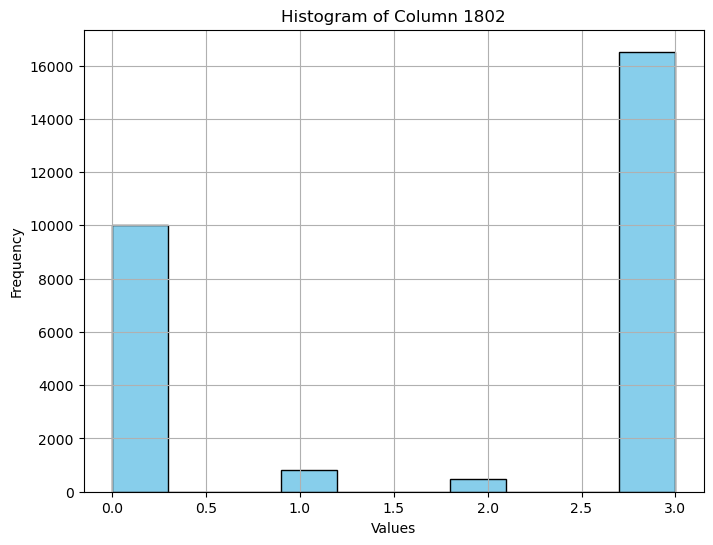

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(training_data['3602'], color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Column 1802')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [9]:
value_mapping = {1.0:1,
                2.0:1,
                3.0:1,
                0.0:0}
                 

training_data['3602'] = training_data['3602'].map(value_mapping)
testing_data['3602']  =  testing_data['3602'].map(value_mapping)

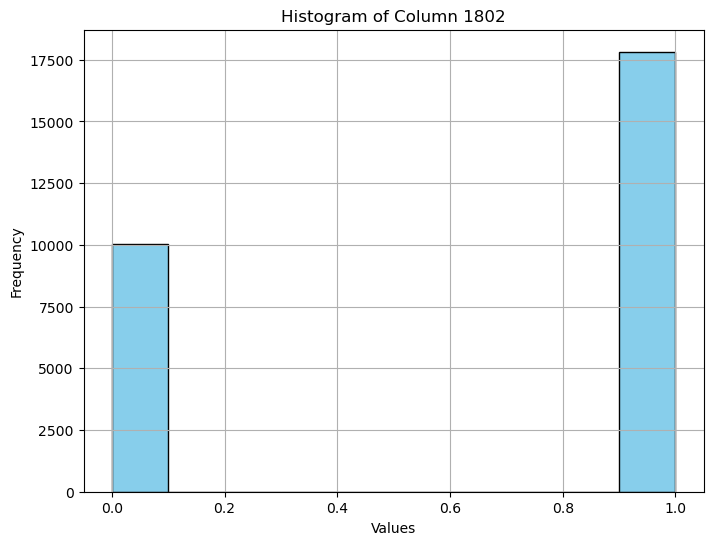

In [10]:
# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(training_data['3602'], color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Column 1802')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

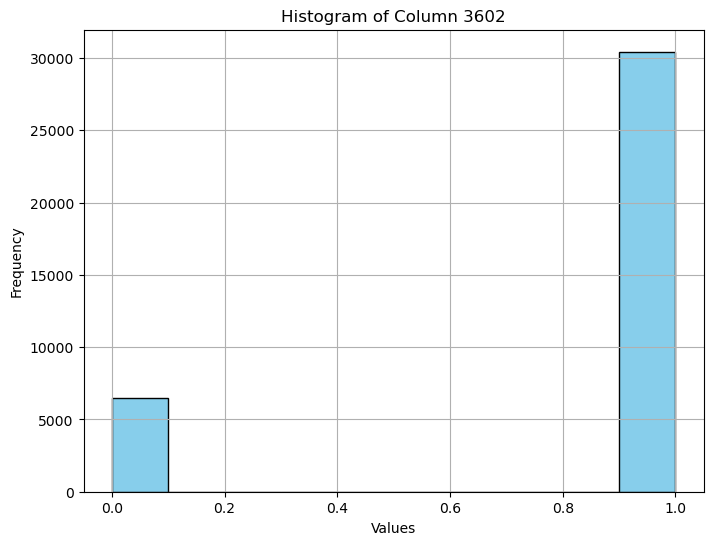

In [11]:
# Plotting the histogram
plt.figure(figsize=(8, 6))
plt.hist(testing_data['3602'], color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Column 3602')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [149]:

# Step 2: Define input and target data
X = training_data.drop(columns=['3602', '3601', '3600','day', 'predicted'])
y = training_data['3602']

# Step 3: Split the data
X_train, X_tester, y_train, y_tester = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 4: Reshape the input data for CNN
X_train = X_train.values.reshape(X_train.shape[0], 30, 30, 4)
X_tester = X_tester.values.reshape(X_tester.shape[0], 30, 30, 4)

# Step 5: One-hot encode the target data
num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_tester_encoded = to_categorical(y_tester, num_classes=num_classes)

Number of classes: 2


In [150]:
X_train.shape

(22276, 30, 30, 4)

In [14]:
# Step 1: Ensure there are no NaN values in the target columns
testing_data.dropna(subset=['3602'], inplace=True)

# Step 2: Define input and target data
X_test = testing_data.drop(columns=['3602', '3601', '3600','day','predicted'])
y_test = testing_data['3602']
# Step 3: Reshape the input data for CNN
X_test = X_test.values.reshape(X_test.shape[0], 30, 30, 4)
y_test_encoded = to_categorical(y_test, num_classes=2)

In [59]:
X_test.shape

(36897, 30, 30, 4)

In [54]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Aliases for convenience
tfd = tfp.distributions
tfpl = tfp.layers

# Define a custom layer to wrap Conv2DFlipout
class Conv2DFlipoutLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, padding='same', activation='relu', **kwargs):
        super(Conv2DFlipoutLayer, self).__init__(**kwargs)
        self.conv2d_flipout = tfpl.Convolution2DFlipout(filters=filters, kernel_size=kernel_size, padding=padding, activation=activation)

    def call(self, inputs):
        return self.conv2d_flipout(inputs)

# Define the main input with shape (30, 30, 4)
main_input = Input(shape=(30, 30, 4))

# Add Bayesian convolutional and regular convolutional layers with batch normalization
x = Conv2DFlipoutLayer(filters=32, kernel_size=3, padding='same', activation='relu')(main_input)
x = BatchNormalization()(x)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 1))(x)
x = Flatten()(x)

# Fully connected layers
x = Dense(128, activation='relu', kernel_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.02))(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)

# Create the model
cnn_model = Model(inputs=main_input, outputs=outputs)

# Compile the model with a learning rate scheduler
cnn_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


C:\Users\kharep\anaconda3\Lib\site-packages\tensorflow_probability\python\layers\util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
C:\Users\kharep\anaconda3\Lib\site-packages\tf_keras\src\initializers\initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
C:\Users\kharep\anaconda3\Lib\site-packages\tensorflow_probability\python\layers\util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [103]:
np.unique(y_test)

array([0, 1], dtype=int64)

In [153]:
from tensorflow.keras import backend as K

K.clear_session()


In [181]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def create_improved_dnn_model(input_shape=(3600,), num_classes=2):
    model = models.Sequential()
    
    # Hidden layer 1 with L2 regularization and Batch Normalization
    model.add(layers.Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    
    # Hidden layer 2
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    # Hidden layer 3
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    
    # Output layer with softmax for multiclass classification
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile the model with a lower learning rate
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Instantiate the model
model = create_improved_dnn_model(input_shape=(3600,))



C:\Users\kharep\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [182]:
# X_train = X_train.reshape(-1, 30 * 30 * 4)
# X_tester = X_tester.reshape(-1, 30 * 30 * 4)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9)
model_checkpoint = ModelCheckpoint('best_bayesian_model.keras', monitor='val_loss', save_best_only=True)

# Compute class weights to handle unbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Train the model
history = model.fit(X_train, y_train_encoded,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_tester, y_tester_encoded),
                    class_weight=class_weights,  # Use class weights for unbalanced data
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])


Epoch 1/50
697/697 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6631 - loss: 1.3801 - val_accuracy: 0.7578 - val_loss: 0.9610 - learning_rate: 5.0000e-04
Epoch 2/50
697/697 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7377 - loss: 0.9775 - val_accuracy: 0.7898 - val_loss: 0.7901 - learning_rate: 5.0000e-04
Epoch 3/50
697/697 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7639 - loss: 0.8013 - val_accuracy: 0.6725 - val_loss: 1.2131 - learning_rate: 5.0000e-04
Epoch 4/50
697/697 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7741 - loss: 0.7075 - val_accuracy: 0.8126 - val_loss: 0.6205 - learning_rate: 5.0000e-04
Epoch 5/50
697/697 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7773 - loss: 0.6354 - val_accuracy: 0.7871 - val_loss: 0.5899 - learning_rate: 5.0000e-04
Epoch 6/50
697/697 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7762 - loss: 0.6159 - val_accuracy: 0.7731 - val_loss: 0.5847 - learning_rate: 5.0000e-04
Epoch 7/50
697/697 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 

1154/1154 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


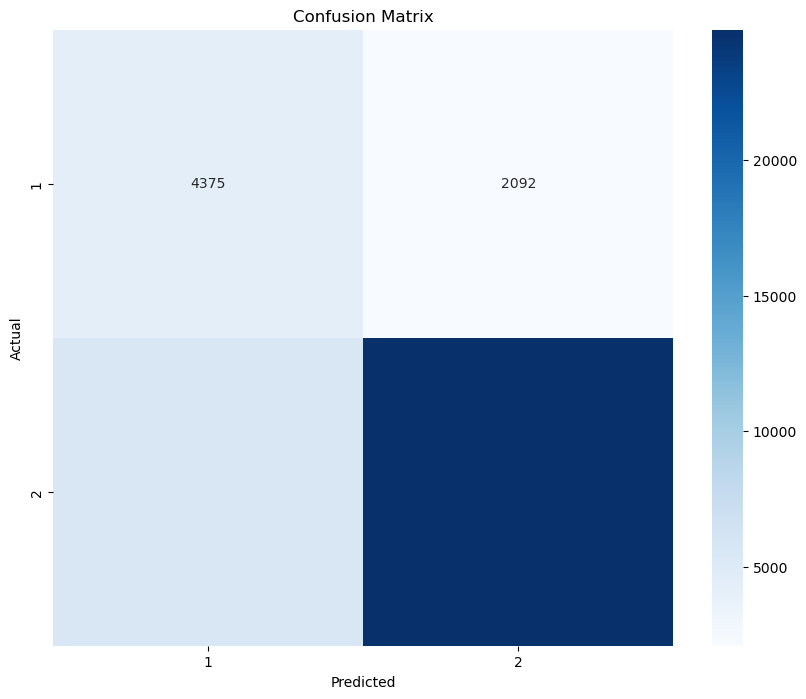

              precision    recall  f1-score   support

           0       0.44      0.68      0.53      6467
           1       0.92      0.82      0.87     30430

    accuracy                           0.79     36897
   macro avg       0.68      0.75      0.70     36897
weighted avg       0.84      0.79      0.81     36897

[[ 4375  2092]
 [ 5627 24803]]


In [183]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_test = X_test.reshape(-1, 30 * 30 * 4)

# Now predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2], yticklabels=[ 1, 2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))
print(conf_matrix)

In [184]:
testing_data['predicted'] = y_pred_classes

In [186]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# Create directory if it doesn't exist
output_dir = 'cnn_predict_bayesian_second_step_0'
os.makedirs(output_dir, exist_ok=True)

# Define color mapping for classes
color_map = {0: (0, 0, 255),  # Blue for class 0
             1: (0, 255, 0),  # Green for class 1
             2: (255, 0, 0),  # Red for class 2
             3: (0, 0, 0)}    # Black for class 3

# Function to create and save images with labels
def create_images_with_labels(df):
    days = df['day'].unique()
    
    for day in days:
        day_data = df[df['day'] == day]

        # Create empty black images for 'Real' and 'Predicted'
        image_real = np.zeros((98, 120, 3), dtype=np.uint8)
        image_pred = np.zeros((98, 120, 3), dtype=np.uint8)

        # Color the images based on the true and predicted classes
        for _, row in day_data.iterrows():
            x, y = int(row['3600']), int(row['3601'])
            true_class = int(row['3602'])
            pred_class = int(row['predicted'])

            if true_class != 3:
                image_real[y, x] = color_map[true_class]

            if pred_class != 3:
                image_pred[y, x] = color_map[pred_class]

        # Convert numpy arrays to PIL images
        img_real = Image.fromarray(image_real)
        img_pred = Image.fromarray(image_pred)

        # Create a white canvas to concatenate images with some space between
        total_width = img_real.width + img_pred.width + 50
        total_height = img_real.height + 40  # Adding space for labels
        canvas = Image.new('RGB', (total_width, total_height), 'white')

        # Paste the real and predicted images onto the canvas
        canvas.paste(img_real, (0, 40))  # 40 pixels down for label space
        canvas.paste(img_pred, (img_real.width + 50, 40))

        # Add labels above the images
        draw = ImageDraw.Draw(canvas)
        font = ImageFont.load_default()

        draw.text((img_real.width // 2 - 20, 10), "Real", fill="black", font=font)
        draw.text((img_real.width + 50 + img_pred.width // 2 - 40, 10), "Predicted", fill="black", font=font)

        # Save the concatenated image
        image_filename = os.path.join(output_dir, f'day_{day}.png')
        canvas.save(image_filename)

# Call the function to create and save images
create_images_with_labels(testing_data)


697/697 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


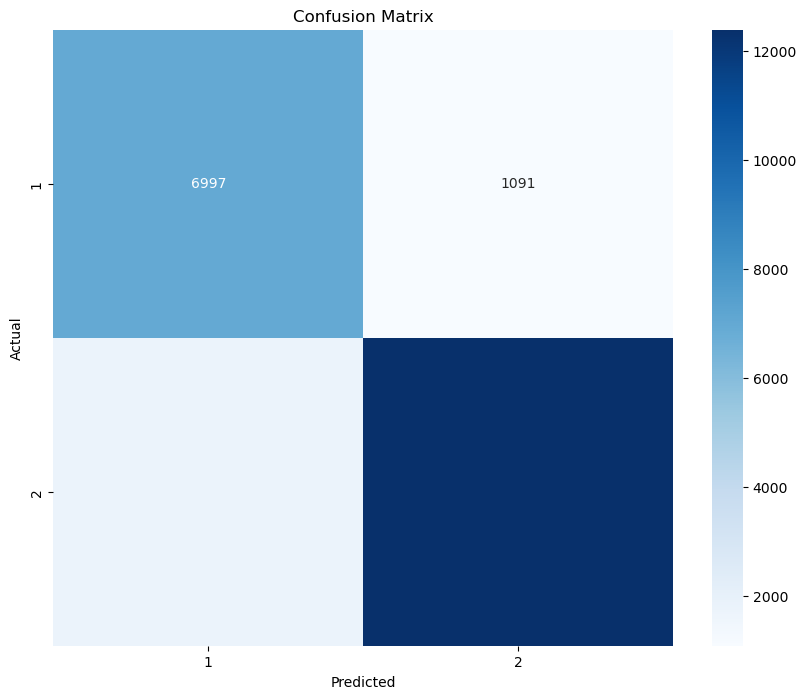

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      8088
           1       0.92      0.87      0.90     14188

    accuracy                           0.87     22276
   macro avg       0.86      0.87      0.86     22276
weighted avg       0.87      0.87      0.87     22276

[[ 6997  1091]
 [ 1795 12393]]


In [171]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Now predict on the test data
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_train

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2], yticklabels=[ 1, 2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))
print(conf_matrix)

In [94]:
cnn_model_15.save('cnn_model.keras')